<a href="https://colab.research.google.com/github/claredavies/Image3DCoursework/blob/main/WarpAffine/WarpAffine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Warp affine transformations

## Task

Given a document image transform it to a scanner like perspective.

Use your own document image.

In [69]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [70]:
!git clone https://github.com/claredavies/Image3DCoursework.git

Cloning into 'Image3DCoursework'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 105 (delta 27), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (105/105), 11.72 MiB | 15.41 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [71]:
%cd Image3DCoursework/WarpAffine

/content/Image3DCoursework/WarpAffine/Image3DCoursework/WarpAffine/Image3DCoursework/WarpAffine


In [72]:
img = cv2.imread("input/input.jpg")
im_scanned = cv2.imread("input/scanned.jpg")

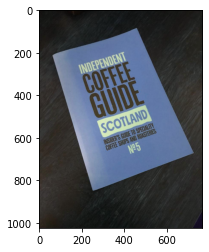

In [73]:
fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(img);

## Document Scanner using Warp Affine

In [74]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect.astype('int').tolist()

In [75]:
def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
 
    return order_points(destination_corners)

In [76]:
def scan(img):
    # Resize image to workable size
    dim_limit = 1080
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)
    # Create a copy of resized original image for later use
    orig_img = img.copy()
    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    # GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img = img * mask2[:, :, np.newaxis]
 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    # Edge Detection.
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
 
    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
 
    # Detecting Edges through Contour approximation.
    # Loop over the contours.
    if len(page) == 0:
        return orig_img
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points.
        if len(corners) == 4:
            break
    # Sorting the corners and converting them to desired shape.
    corners = sorted(np.concatenate(corners).tolist())
    # For 4 corner points being detected.
    corners = order_points(corners)
 
    destination_corners = find_dest(corners)
 
    h, w = orig_img.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    # Perspective transform using homography.
    final = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]),
                                flags=cv2.INTER_LINEAR)
    return final

In [77]:
final = scan(img)

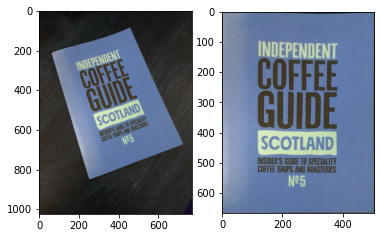

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img);
ax2.imshow(final);